# Homework 1

In this homework, we apply a linear regression to learn the dynamics of a system. 

<hr style="clear:both">

This homework is part of a series of homeworks for the ME-390-EPFL Foundations of Artificial Intelligence course at EPFL. Copyright (c) 2022 [Sycamore](https://www.epfl.ch/labs/sycamore/) lab at EPFL.
Use of this source code is governed by an MIT-style license that can be found in the LICENSE file or at https://www.opensource.org/licenses/MIT

**Author(s):** Tony Wood, Andreas Schlaginhaufen, Loris di Natale

### Name and SCIPER

**Name:** Mathis Lettermann

**SCIPER:** 315497

### Homework info 
**Released:** Monday, October 10, 2022  
**Submission**: Wednesday October 19, 2022 (before 11:59PM) on Moodle  
**Grade weight:** 10% of the overall grade  
**This is an individual assignment, the exchange of code between students is forbidden.**

This homework is composed of 4 parts: 
- Part 1: Data loading & pre-processing (2 pts)
- Part 2: Linear regression (3 pts)
- Part 3: Regularization (3 pts)
- Part 4: Analysis and conclusions (2 pts)

**Total:** 10 pts

**Work through this exercise in order, as functions implemented early on can be used for later parts.**

**Instructions:**
- Work on your own file: create a copy of this notebook. Rename the copy by putting your SCIPER (name it **SCIPER_homework1.ipynb**). To do so, right click on the notebook in the left sidebar and select **"Rename"**. For example, if your SCIPER is 123456, then name your notebook *123456_homework1.ipynb* .
- Use the Table of Contents extension to quickly navigate to each part.
- In order to ensure that there are no hidden states in your notebook, frequently restart the kernel using: **Kernel -> Restart Kernel and Run all Selected Cells...**

Good luck!

## Task description

In this homework, you are asked to learn the model of a controlled ground robot from measurement data. The state of the robot is represented by its pose, $\mathbf{x}(t) := \begin{bmatrix}p_0(t),p_1(t),\varphi(t)\end{bmatrix}^\top \in \mathbb{R}^3$, where $p_0$ and $p_1$ are position coordinates and $\varphi$ is the orientation of the robot. The model of the robot is given by the following ordinary differential equation, 

$$ \dot{\mathbf{x}}(t) = \begin{bmatrix} \dot{p}_0(t) \\ \dot{p}_1(t) \\ \dot{\varphi}(t) \end{bmatrix} = f(\mathbf{x}(t)) = \begin{bmatrix} 
f_{p_0}(\mathbf{x}(t)) \\
f_{p_1}(\mathbf{x}(t)) \\
f_{\varphi}(\mathbf{x}(t)) 
\end{bmatrix}, $$ 

for some unknown $f:\mathbb{R}^3\to\mathbb{R}^3$ that you want to identify. You can assume that each component of $f$ can be represented by a linear feature model $f_i(\mathbf{x}; {\mathbf{w}}_i)=\mathbf{w}_i^\top\mathbf{\Phi}(\mathbf{x})$ for $i=1,2,3$, where $\mathbf{w}_i^\top$ denotes the transpose of the vector $\mathbf{w}_i$. Moreover, $\mathbf{\Phi}(\mathbf{x})=\begin{bmatrix}1, p_0,p_1,\varphi, \cos(\varphi), \sin(\varphi)\end{bmatrix}^\top\in\mathbb{R}^{6}$ is the feature vector and $\mathbf{w}_i\in\mathbb{R}^{6}$ for $i=1,2,3$ are the parameters for each component.  

Your task is to use linear regression to learn the optimal model parameters $\mathbf{w}^*_i$ for $i=1,2,3$.

## Part 0: Imports

### 0.1 Imports and helpers for plotting
Before starting the exercise, we need to generate the data to train our models

Run this code to import packages and customize the settings of matplotlib to create beautiful plots.

In [1]:
import matplotlib
import numpy as np
import pandas as pd
from typing import Tuple

#this next line is only needed in iPython notebooks
%matplotlib inline 
import math
import matplotlib.font_manager as fm
font = fm.FontProperties(size = 12)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

### 0.2 Import helper functions

To help you throughout this homework, we prepared a few helper functions. You can find them in `functions.py`.  
Feel free to browse this file - you shouln't need to edit anything.



In [2]:
from functions import _fix_seed, generate_trajectories, plot_trajectories, generate_X_Y, separate_trajectories, plot_data, predict_and_plot

## Part 1: Data generation

Let us define the state of the robot as $\mathbf{x} := \begin{bmatrix}p_0,p_1,\varphi\end{bmatrix}^\top$, where $p_0$ and $p_1$ are position coordinates and $\varphi$ is the orientation of the robot.

The true behaviour of the differential wheeled robot are given by the following equations, 
$$ \dot{\mathbf{x}} = \begin{bmatrix} \dot{p}_0 \\ \dot{p}_1 \\ \dot{\varphi} \end{bmatrix} = f(\mathbf{x}) = \begin{bmatrix} 
f_{p_0}(\mathbf{x}) \\
f_{p_1}(\mathbf{x}) \\
f_{\varphi}(\mathbf{x}) 
\end{bmatrix} = \begin{bmatrix} v \cdot \cos(\varphi) \\ v \cdot \sin(\varphi) \\ \omega \end{bmatrix}$$
where the speed, $ v$, and the turn rate, $\omega$, are kept constant. The training data will consist of noisy state measurements sampled along different trajectories of the system.

Note: A trajectory of the robot refers to the sequence of states $p_0(t), p_1(t), \varphi(t)$ generated from a given initial condition $p_0(0), p_1(0), \varphi(0)$ over a time interval $t \in [0, T]$. 

The following simulation data is generated with parameter values, 
$$ v = 0.5 \textrm{m/s}, $$
$$ \omega = - \pi / 3.$$

**Question:** What would the trajectories look like in the 2 dimensional space, $p_0$, $p_1$? 

**Answer:** They would be a circle.

### 1.1 Simulating the System: train and test data

Using the equations above and the helper functions `generate_trajectories` and `plot_trajectories`, you can generate a train and a test dataset as follows.  

Note that we use `_fix_seed` to fix a random seed. This ensures reproducibility, i.e. all random operations can be repeated. 

#### Train data
We generate trajectories of the robot from different initial conditions. The state variables are measured with some noise. Hence, we have noisy measurements of $p_0(t), p_1(t), \varphi(t)$ starting from a random initial condition $p_0(0), p_1(0), \varphi(0)$, over a time interval $t \in [0,T]$

In [5]:
#####
_fix_seed(7) # DO NOT CHANGE FOR SUBMISSIONS _fix_seed(7)
#####

number_trajectories_train = 10
noise = 0.001


# Generate the train data 
# This returns a set of trajectories (it is in the pandas dataframe format and can be converted to numpy)
dfs_train = generate_trajectories(number_trajectories_train, noise)

print(f'\nNumber of dataframes:\t{len(dfs_train)}')
print(f'Shape of one dataframe:\t{dfs_train[0].shape}\n')

display(dfs_train[1].head())


Number of dataframes:	10
Shape of one dataframe:	(2500, 4)



,t,p_0,p_1,phi
0,0.00,-0.157089,0.340074,-1.435616
1,0.02,-0.160404,0.331301,-1.446044
2,0.04,-0.156794,0.318155,-1.468128
3,0.06,-0.152876,0.307034,-1.492291
4,0.08,-0.151971,0.301004,-1.513196


#### Test data

We generate the trajectories of the robot the same way as we generated the training set but from a different initial condition and different noise sequence. 

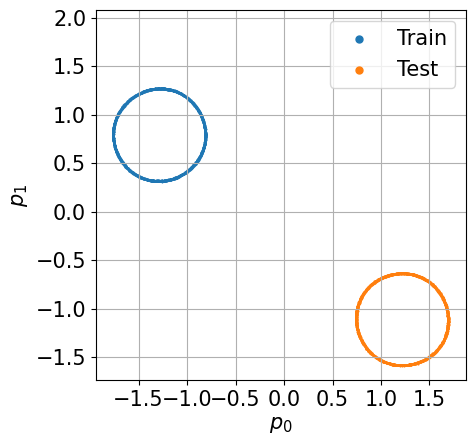

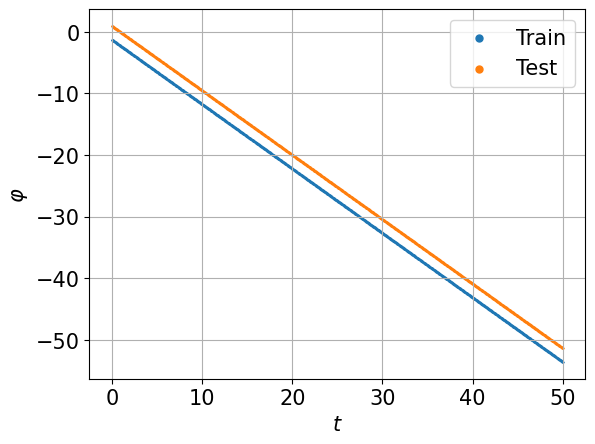

In [6]:
#####
_fix_seed(13434252) #DO NOT CHANGE FOR SUBMISSIONS _fix_seed(13434252)
#####

number_trajectories_test = 10
noise = 0.001

# Generate test data
dfs_test = generate_trajectories(number_trajectories_test, noise)

# Plot the last train and test trajectory - just one trajectory for each
plot_trajectories([dfs_train[-1], dfs_test[-1]], labels=['Train', 'Test'])

### 1.2 Generate the targets

As you can see, each trajectory contains information about the time step and state, i.e. $\lbrace(t^i, \mathbf{x}^i)\rbrace_{i=1}^N$ with $ \mathbf{x}^i:= \mathbf{x}(t^i)$ sampled at an equal rate $\Delta t=t_{i+1} - t_{i}$.  

However, recall that we want to approximate $f$, i.e. the derivative $\dot{x}$, which we don't have in the data. Hence, you first need to generate the targets $\mathbf{y}^i := f(\mathbf{x}^i) = \dot{\mathbf{x}}(t^i) $.  
Since the true $\dot{\mathbf{x}}(t^i)$ is unknown, you can approximate it via the finite difference:
$$\dot{\mathbf{x}}(t^i)\approx \dfrac{\mathbf{x}(t^{i+1})-\mathbf{x}(t^{i})}{t^{i+1}-t^i}.$$

Your first exercise is to complete the function below to generate these targets (you can drop the last data point of each trajectory for simplicity, because you don't know $x^{N+1}$).

In [7]:
def generate_target(df: pd.DataFrame) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Generate targets via finite differences.
    
    Args:
        df (pd.DataFrame): Dataframe containing trajectory data
        
    Returns:
        X (np.ndarray): State measurements, Array of shape (trajectory_length-1, 3)
        Y (np.ndarray): Finite differences, Array of shape (trajectory_length-1, 3)
        t (np.ndarray): Time vector, Array of shape (trajectory_length-1,)
    """
    # here, we convert the dataframe to numpy format
    X = df[['p_0', 'p_1', 'phi']].to_numpy()
    t = df['t'].to_numpy()
    Y = np.zeros((len(t)-1, 3))
    
    
    ### START CODE HERE ### (≈ 3 lines of code)
    # Hint: review numpy indexing array
    Y = np.diff(X, axis=0)/(np.diff(np.reshape(t,(len(t),1)), axis=0)*np.ones((X.shape[0]-1,3))) # divisor = 0.02 is basically the same but i want to use the matrices
    X = X[0:-1]
    t = np.reshape(t[0:2499], (len(t)-1, 1))
    ### END CODE HERE ###
    
    return X, Y, t

You can now use the provided `generate_X_Y` function to generate the X and Y that we will use later, both for the training and test data.  Note that this function merges the 10 training trajectories in a single dataframe. It does the same for the test trajectories. For visualization, later on, we separate the test trajectories into 10 sets. 

In [8]:
# Generate the data and have a look at the evaluation data we created
df_train, df_test = generate_X_Y(dfs_train, dfs_test, generate_target)

# We now have the time, the 3 states (X), and the derivatives (Y) together
print('\nShape of the test data:', df_test.shape, '\n')
df_test.head()

ValueError: Per-column arrays must each be 1-dimensional

As expected, this added the needed (approximate) derivatives to the data. This allows us to define X and Y below.  
Note that we use a helper function to separate the trajectories of the test set to provide nicer plots in the rest of the notebook.

In [ ]:
# Use the entire data for training
X_train = df_train[['p0', 'p1', 'phi']].to_numpy()
Y_train = df_train[['dp0dt', 'dp1dt', 'dphidt']].to_numpy()
X_test = df_test[['p0', 'p1', 'phi']].to_numpy()
Y_test = df_test[['dp0dt', 'dp1dt', 'dphidt']].to_numpy()

# For plotting, we only consider one trajectory at a time
# This function separates the test data into separate trajectories
t_test_trajs, X_test_trajs, Y_test_trajs = separate_trajectories(df_test, number_trajectories_test)

print(f'We have {len(X_test_trajs)} test trajectories')

### 1.3 Data Preview
We can now check what X and Y look like, for example on the fifth test trajectory.

In [ ]:
trajectory = 2

plot_data(t_test_trajs[trajectory], X_test_trajs[trajectory], Y_test_trajs[trajectory])

## Part 2: Linear Regression: preliminaries

In this part, you are required to learn the model parameters via linear regression.

### 2.1 Pre-compute the features 
First, you need to implement the feature map:
$$\mathbf{X}:=\begin{bmatrix} {\mathbf{x}^1}^\top \\ \vdots \\ {\mathbf{x}^N}^\top \end{bmatrix} \mapsto \mathbf{\Phi}(\mathbf{X}):=\begin{bmatrix} \mathbf{\Phi}(\mathbf{x}^1)^\top \\ \vdots \\ \mathbf{\Phi}(\mathbf{x}^N)^\top \end{bmatrix}.$$
Recall, $\mathbf{x}^\top$ denotes the transpose of the vector $\mathbf{x}$, $\mathbf{X}\in \mathbb{R}^{N\times 3}$ is the input data matrix, and $\mathbf{\Phi}(\mathbf{x})=\begin{bmatrix}1,p_0,p_1,\varphi, \cos(\varphi), \sin(\varphi)\end{bmatrix}^\top\in\mathbb{R}^{6}$.

In [ ]:
# Complete the code below (element-wise numpy operations may be useful):
def feature_map(X: np.ndarray) -> np.ndarray:
    """ 
    Generates feature map from input data matrix.
    
    Args: 
        X (np.ndarray): Input data matrix, shape (N,3)
        
    Returns:
        Phi(X) (np.ndarray): Feature matrix, shape (N,6)
    """
    
    
    ### START CODE HERE ### (≈ 3 lines of code)
    # ...
    # feature_matrix = ...
    ### END CODE HERE ###
    
    return feature_matrix


nfeatures = feature_map(X_train).shape[1]

print(f'\nOriginal shape of X: {X_train.shape}')
print(f'Shape after the feature map has been applied: {feature_map(X_train).shape}\n')

### 2.2 Define the linear model

Now that the feature map is defined, you can use it to define your linear model $f_i(\mathbf{x}; {\mathbf{w}}_i)=\mathbf{w}_i^\top\mathbf{\Phi}(\mathbf{x})$ for $i=1,2,3$.  
Note that the model is the same for each component, only the parameter $w_i$ differs, so you only need to define one $f$ below.


**Question:** Expand the term: $\mathbf{w}_1^\top\mathbf{\Phi}(\mathbf{x})$ into its 6 components. You may use $\mathbf{w}_{1,j}$ to refer to $j$-th element of $\mathbf{w}_1$.

**Answer:** ...

In [ ]:
# define model and parameters (including bias)
w_1 = np.zeros(nfeatures)
w_2 = np.zeros(nfeatures)
w_3 = np.zeros(nfeatures)

# implement the linear model
def f(X: np.ndarray, w: np.ndarray) -> np.ndarray:
    """
    Linear regression model.
    
    Args:
        X (np.ndarray): Input data matrix, shape (N,3)
        w (np.ndarray): Weight vector, shape (6,)
        
    Returns:
        f(X, w) (np.ndarray): Predicted targets, shape (N,)
    """
    
    ### START CODE HERE ### (≈ 1 line of code)
    # return ....
    ### END CODE HERE ###


print(f(X_train, w_1).shape)

You will learn one vector of weigths for each dimension, we hence separate the targets.

In [ ]:
# Split target into the three components to predict separately
y_1_train = Y_train[:,0]
y_2_train = Y_train[:,1]
y_3_train = Y_train[:,2]

y_1_test = Y_test[:,0]
y_2_test = Y_test[:,1]
y_3_test = Y_test[:,2]

### 2.3 Mean Square Error
You are now asked to implement a method to compute the Mean Squared Error (MSE) $J$, which is defined as:
$$
\begin{align}
J(\mathbf{w}_i) = \frac{1}{N} (\mathbf{\Phi}(\mathbf{X}) \mathbf{w}_i-\mathbf{y})^{T} (\mathbf{\Phi}(\mathbf{X}) \mathbf{w}_i-\mathbf{y}).
\end{align}$$
Above $\mathbf{\Phi}(\mathbf{X}) \in \mathbb{R}^{N \times 6}$

In [ ]:
def mse_loss(X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
    """Computes the Mean Square Error (MSE)
    
    Args:
        X (np.ndarray): Dataset of shape (N, 3)
        y (np.ndarray): Labels of shape (N, )
        w (np.ndarray): Weights of shape (6, )

    Returns:
        float: the MSE loss
    """
    ### START CODE HERE ### (≈ 3 lines of code)
    # ...
    # loss = ...
    ### END CODE HERE ###
    
    return loss

# Test it on the first training dimension with the weight initialized as 0:
print(f'Loss on dimension 1 with w1=0: {mse_loss(X_train, y_1_train, w_1): .3f}')

### 2.4: Least squares method
Estimate the optimal parameters $\mathbf{w}_i^*$ via the least squares method seen in the exercises.

In [ ]:
def least_squares(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    """Solves linear regression using least squares

    Args:
        X: Data of shape (N, 3)
        y: Labels of shape (N, )

    Returns:
        Weight parameters of shape (6, )
    """

    ### START CODE HERE ### (≈ 1 line of code)
    # w = ...
    ### END CODE HERE ###
    
    return w

Use your function to train w1, w2, and w3. You can then use the provided `predict_and_plot` function to check your implementations.

In [ ]:
w_1 = least_squares(X_train, y_1_train)
w_2 = least_squares(X_train, y_2_train)
w_3 = least_squares(X_train, y_3_train)

# print the train error for each dimension
print(f'Train error on dimension 1: {mse_loss(X_train, y_1_train, w_1): .5f}')
print(f'Test error dimension 1: {mse_loss(X_test, y_1_test, w_1): .5f}')
print(f'Train error on dimension 2: {mse_loss(X_train, y_2_train, w_2): .5f}')
print(f'Test error dimension 2: {mse_loss(X_test, y_2_test, w_2): .5f}')
print(f'Train error on dimension 3 : {mse_loss(X_train, y_3_train, w_3): .5f}')
print(f'Test error dimension 3: {mse_loss(X_test, y_3_test, w_3): .5f}')

# Plot the prediction along the first test trajectory as an example
print('Test prediction:')
for i in range(1):
    predict_and_plot(X_test_trajs[i], Y_test_trajs[i], t_test_trajs[i], w_1, w_2, w_3, feature_map)

**Question:** Is the model overfitting, underfitting or performing well? 

**Answer:** ...

In [ ]:
# You can also plot several trajectories together, but it becomes hard to see the difference
predict_and_plot(X_test_trajs[:5], Y_test_trajs[:5], t_test_trajs[:5], w_1, w_2, w_3, feature_map)

## Part 3: Ridge regression

Similarly to the classical least square regression above, you are now tasked to implement the Ridge regression

**Question:** Explain the motivation for regularization in a supervised learning problem. How would you expect the regularization influence the generalization for this specific problem? 

**Answer:**
...


### 3.1 Ridge regularized MSE loss function

**Question:** For a component $i$, write the MSE loss function with ridge regularization. Exclude $\mathbf{w}_{i, 0}$ from the regularization!

**Answer:**
...

Implement the ridge regression in the code below. 

In [ ]:
def ridge_regression(X: np.ndarray, y: np.ndarray, lambda_: float) -> np.ndarray:
    """Solves linear regression using least squares

    Args:
        X: Data of shape (N, 3)
        y: Labels of shape (N, )
        lambda_: regularization parameter

    Returns:
        Weight parameters of shape (6, )
    """

    ### START CODE HERE ### (≈ 4 lines of code)
    # ...
    # w = ...
    ### END CODE HERE ###
    
    return w


And train for a set of ridge coefficients $\lambda$

In [ ]:
lambdas = [1e-4, 1e-2, 1.0, 1e2]
w_1_ridge = []
w_2_ridge = []
w_3_ridge = []
for i, lambda_ in enumerate(lambdas):
    print('Lambda: ', lambda_)
    
    w_1_ridge.append(ridge_regression(X_train, y_1_train, lambda_))
    w_2_ridge.append(ridge_regression(X_train, y_2_train, lambda_))
    w_3_ridge.append(ridge_regression(X_train, y_3_train, lambda_))

    # print the train error for each dimension
    print(f'Train error on dimension 1: {mse_loss(X_train, y_1_train, w_1_ridge[i]): .5f}')
    print(f'Test error dimension 1: {mse_loss(X_test, y_1_test, w_1_ridge[i]): .5f}')
    print(f'Train error on dimension 2: {mse_loss(X_train, y_2_train, w_2_ridge[i]): .5f}')
    print(f'Test error dimension 2: {mse_loss(X_test, y_2_test, w_2_ridge[i]): .5f}')
    print(f'Train error on dimension 3 : {mse_loss(X_train, y_3_train, w_3_ridge[i]): .5f}')
    print(f'Test error dimension 3: {mse_loss(X_test, y_3_test, w_3_ridge[i]): .5f}')

    print('Prediction:')
    # Plot prediction along first trajectory
    for j in range(1):
        predict_and_plot(X_test_trajs[j], Y_test_trajs[j], t_test_trajs[j], w_1_ridge[i], w_2_ridge[i], w_3_ridge[i], feature_map)

### 3.2 Print learned weight vectors

Compare the learned weight vectors $\mathbf{w}_i$ for various values of $\lambda$.

In [ ]:
### Weigt vectors

print('w_1:')
# w_1
print('lambda = 0.00: ', w_1)
for (i, lambda_) in enumerate(lambdas):
    print(f'lambda = {lambda_:.2e}: ',  w_1_ridge[i])

print('\nw_2:')
# w_2
print('lambda = 0.00: ', w_2)
for (i, lambda_) in enumerate(lambdas):
    print(f'lambda = {lambda_:.2e}: ',  w_2_ridge[i])

print('\nw_3:')
# w_1
print('lambda = 0.00: ', w_3)
for (i, lambda_) in enumerate(lambdas):
    print(f'lambda = {lambda_:.2e}: ',  w_3_ridge[i])

### 3.3 Norm of parameters

Compare $||\mathbf{w}_i||_2$ for the different choices of the regularization parameter $\lambda$.

In [ ]:
### Two norm of weights

print('norm of w_1:')
# w_1
print('lambda = 0.00: ', f'{math.sqrt(w_1.T @ w_1):.5f}')
for (i, lambda_) in enumerate(lambdas):
    print(f'lambda = {lambda_:.2e}: ',  f'{math.sqrt(w_1_ridge[i].T @ w_1_ridge[i]):.5f}')

print('\nnorm of w_2:')
# w_1
print('lambda = 0.00: ', f'{math.sqrt(w_2.T @ w_2):.5f}')
for (i, lambda_) in enumerate(lambdas):
    print(f'lambda = {lambda_:.2e}: ',  f'{math.sqrt(w_2_ridge[i].T @ w_2_ridge[i]):.5f}')
    
print('\nnorm of w_3:')
# w_1
print('lambda = 0.00: ', f'{math.sqrt(w_3.T @ w_3):.5f}')
for (i, lambda_) in enumerate(lambdas):
    print(f'lambda = {lambda_:.2e}: ',  f'{math.sqrt(w_3_ridge[i].T @ w_3_ridge[i]):.5f}')

## Part 4: Analysis and remarks

Feel free to add a few cells below to illustrate you answers.

**Question**: What is the impact of $\lambda$ in the Ridge regresion?

**Answer**: ...


**Bonus Question**: What is the impact of the number of trajectories in the training data? Would a single trajectory suffice to identify the system for the given feature vector? Try to justify your answer experimentally and theoretically.

**Answer**: ...

# Submitting your homework

### Restarting the kernel

Before submitting, make sure that there are no [hidden states](https://github.com/vita-epfl/introML-2021/blob/main/exercises/00-setup/jupyter.md#the-kernel) by restarting your kernel and running all cells. Check that the code runs without errors.

In [ ]:
# Restart your kernel and run all cells, make sure that you can reach this cell
print("Ran all cells :)")

### Renaming this notebook

Rename this notebook by preprending your SCIPER (name it **SCIPER_homework1.ipynb**). To do so, right click on the notebook in the left sidebar and select **"Rename"**.

For example, if your SCIPER is 123456, then name your notebook *123456_homework1.ipynb* .

### Submitting on Moodle

Finally, make sure to save your notebook (File -> Save Notebook), so that it has your most recent changes. Then:
- If you are working on a **local** environment, you can directly upload this notebook (i.e. the file you are currently working on) to Moodle.
- If you are using a **cloud-based** environment such as **EPFL Noto**, you'll first need to get a local copy by right clicking on the notebook in the sidebar and clicking on **"Download"**, then upload the downloaded notebook to Moodle.